In [1]:
from pkg_resources import resource_filename
import os
import warnings
import numpy as np

from cts_core.camera import Camera
from digicampipe.utils import geometry
from digicampipe.io.event_stream import event_stream, add_slow_data

example_file_path = resource_filename(
    'digicampipe',
    os.path.join(
        'tests',
        'resources',
        'example_100_evts.000.fits.fz'
    )
)

digicam_config_file = resource_filename(
    'digicampipe',
    os.path.join(
        'tests',
        'resources',
        'camera_config.cfg'
    )
)

aux_basepath = resource_filename('digicampipe', 'tests/resources/')


digicam = Camera(_config_file=digicam_config_file)
digicam_geometry = geometry.generate_geometry_from_camera(camera=digicam)



data_stream = event_stream(
    file_list=[example_file_path],
    camera_geometry=digicam_geometry,
    camera=digicam,
    max_events=100
)
data_stream = add_slow_data(data_stream, basepath=aux_basepath)
for event in data_stream:
    pass

/home/dneise/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
event

digicampipe.io.containers.DataContainer:
                          r0.*: Raw Data
                          r1.*: Raw Common Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                        inst.*: Instrumental information
                     slow_data: Slow Data Information

In [3]:
# I do not show this, it is VERY long and ugly
# event.slow_data

In [4]:
# slow_data return a `collections.namedtuple` at the moment
# namedtuples tell you their fields with: `._fields`  (yes, it should be keys(), but I did not write it.)
event.slow_data._fields

('DigicamSlowControl',
 'MasterSST1M',
 'PDPSlowControl',
 'SafetyPLC',
 'DriveSystem')

In [5]:
# each field of `slow_control` at the moment is also a namedtuple namedtuple
# I do not show this, it is long and ugly
# event.slow_data.DigicamSlowControl

In [6]:
event.slow_data.DigicamSlowControl._fields

('timestamp',
 'Crate1_timestamps',
 'Crate3_T',
 'Crates',
 'Crate2_T',
 'cstSwitches',
 'appStatus',
 'Crate1_status',
 'FadcResync',
 'Crate2_timestamps',
 'Crate1_T',
 'AbsoluteTime',
 'trigger_status',
 'Crate3_status',
 'FadcOffset',
 'triggerParameters',
 'opcuaTime',
 'triggerSwitches',
 'Crate2_status',
 'cstParameters',
 'Crate3_timestamps',
 'LocalTime',
 'trigger_timestamp',
 'triggerStatus')

In [7]:
event.slow_data.DigicamSlowControl.trigger_status

0

In [8]:
# I do not show this, it is long and ugly
# event.slow_data.DriveSystem

In [9]:
event.slow_data.DriveSystem._fields

('timestamp',
 'operation_aborted_error_description',
 'no_permission_error_description',
 'system_is_busy_error_rev',
 'current_track_step_pos_el',
 'has_id',
 'operation_stopped_error_rev',
 'invalid_operation_error_ec',
 'recent_error_rev',
 'is_moving',
 'in__v_rel',
 'in__track_step_pos_el',
 'has_remote_mode_requested',
 'has_firmware_release',
 'current_track_step_pos_az',
 'is_tracking',
 'current_track_step_t',
 'is_in_park_position',
 'is_in_parking_zone',
 'is_on_source',
 'in__track_step_pos_az',
 'system_is_busy_error_crit_time',
 'operation_stopped_error_ec',
 'invalid_operation_error_crit_time',
 'current_max_velocity_el',
 'current_max_velocity_az',
 'operation_aborted_error_crit_time',
 'current_position_el',
 'capacity_exceeded_error_ec',
 'invalid_operation_error_rev',
 'system_is_busy_error_ec',
 'invalid_operation_error_description',
 'current_nominal_position_az',
 'capacity_exceeded_error_rev',
 'operation_stopped_error_description',
 'current_time',
 'in__positi

In [10]:
event.slow_data.DriveSystem.current_time

1509415494066

In [11]:
event.slow_data.DriveSystem.current_position_az

-166.022

In [12]:
event.slow_data.DriveSystem.current_position_el

61.696793

# How does it look for multiple files?

In [13]:
data_stream = event_stream(
    file_list=[example_file_path],
    camera_geometry=digicam_geometry,
    camera=digicam,
    max_events=100
)
data_stream = add_slow_data(data_stream, basepath=aux_basepath)
events = [e for e in data_stream]

In [14]:
len(events)

100

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

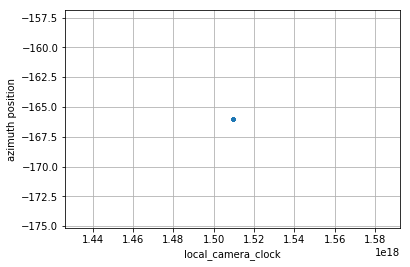

In [16]:
# events is a normal python list, so something like:
#     events.DriveSystem.current_position_az
# obviously cannot work.
plt.plot(
    [e.r0.tel[1].local_camera_clock for e in events],
    [e.slow_data.DriveSystem.current_position_az for e in events],
    '.:',
)
plt.xlabel('local_camera_clock')
plt.ylabel('azimuth position')
plt.grid()

### The upper plot shows only a single point, because the `event_source` does not emit individual events
See prove below

In [17]:
e0 = events[0]
all([e0 is e for e in events])

True